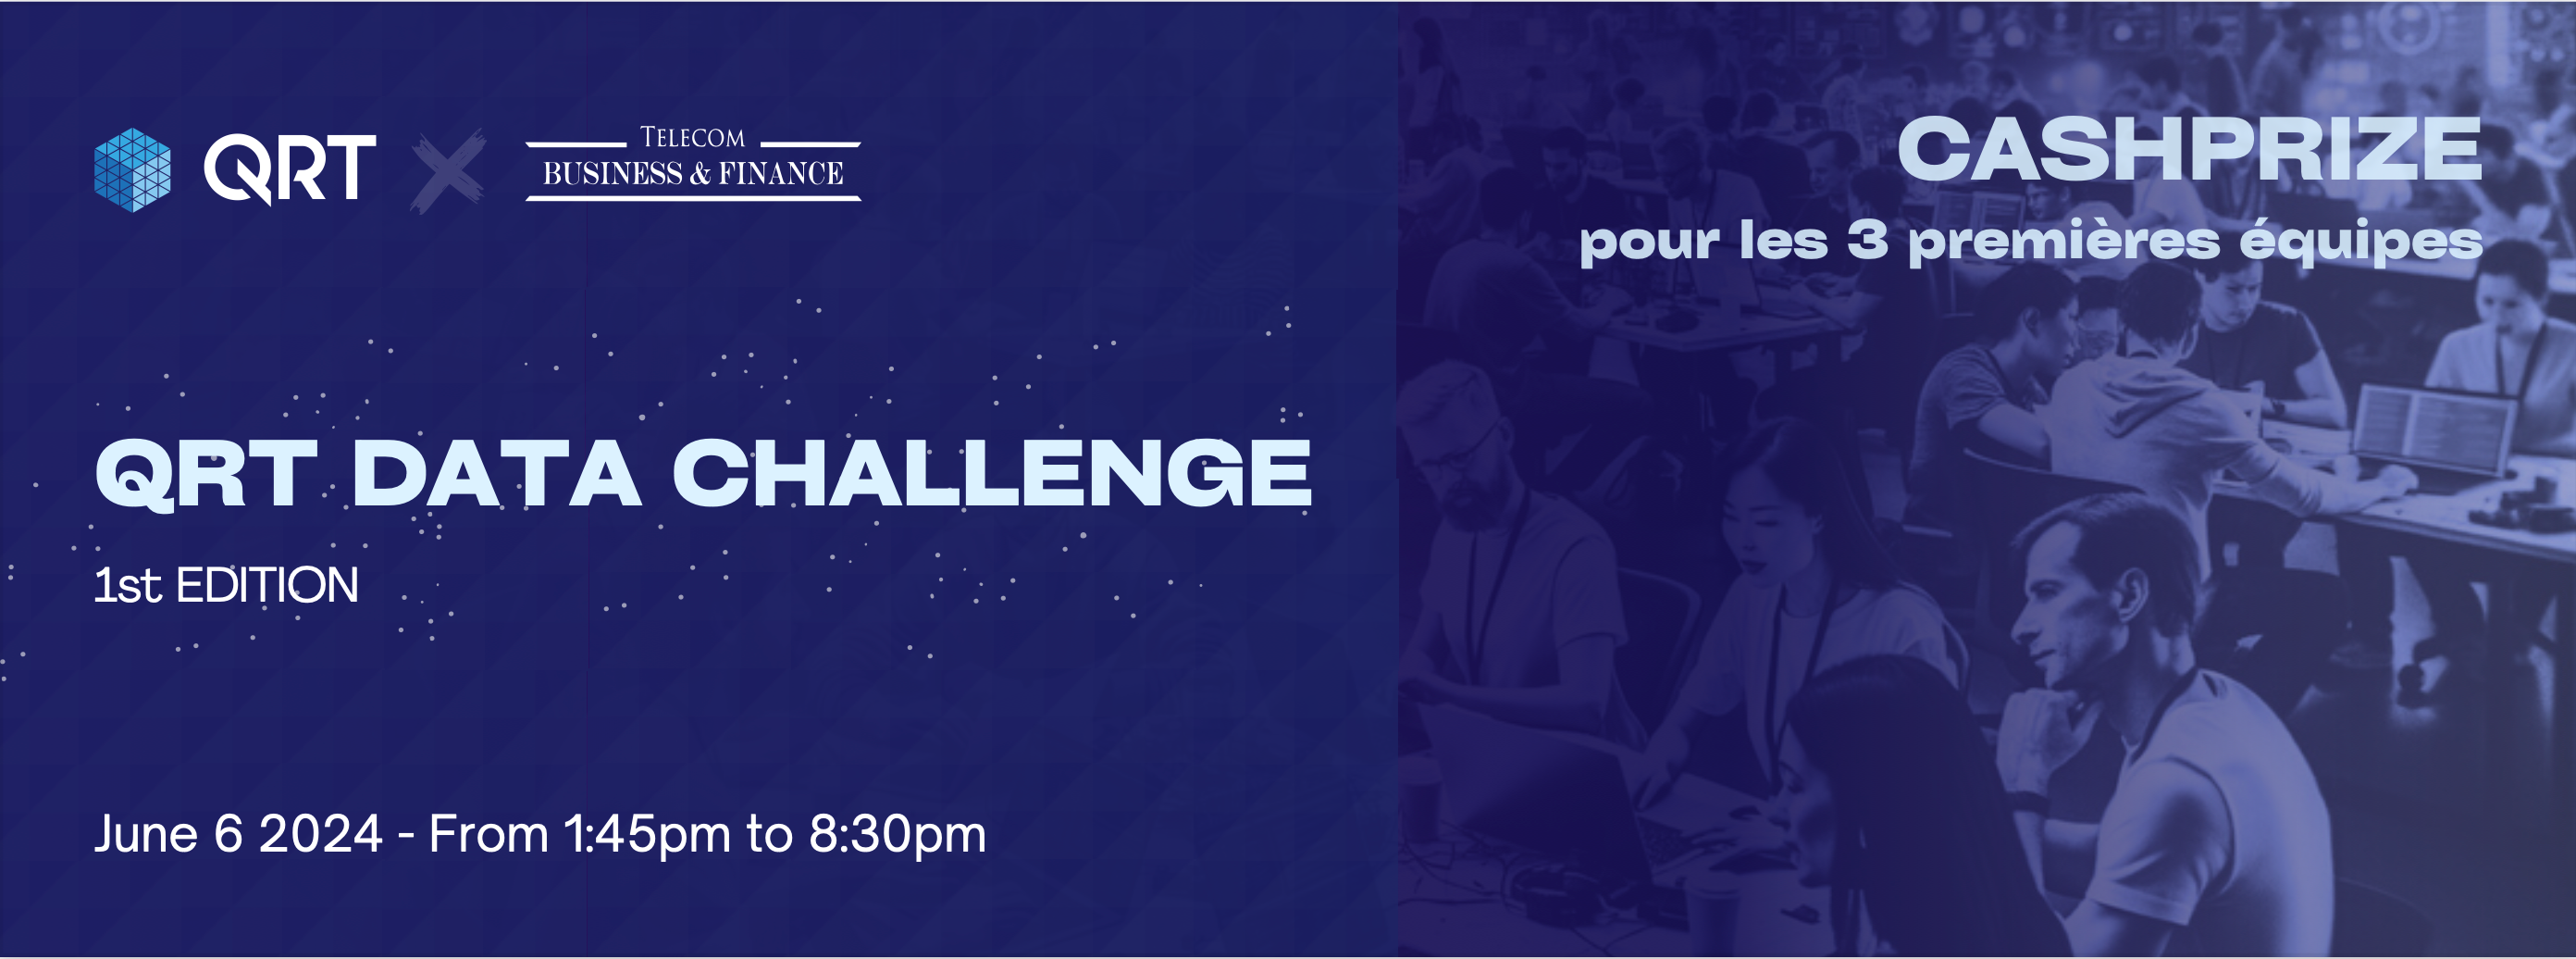

<h1 style="text-align: center;"> Team : Achraf, Ayoub & Yann</h1>

# Importing Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import optuna
from optuna.integration import CatBoostPruningCallback, XGBoostPruningCallback
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, make_scorer
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer

from sklearn.decomposition import PCA

import tensorflow as tf
keras = tf.keras
from keras.callbacks import EarlyStopping

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


warnings.filterwarnings("ignore")

c:\Users\Main_YnFb\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Apply the patch to scikit-learn to use optimized algorithms provided by sklearnex
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Train Data Loading & Preprocessing

In [15]:
# Load train team statistics from CSV file into a DataFrame
train_home_team_statistics_df = pd.read_csv(
    'train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv(
    'train_away_team_statistics_df.csv', index_col=0)

train_scores = pd.read_csv('Y_train_1rknArQ.csv', index_col=0)

train_home = train_home_team_statistics_df.iloc[:, 2:]
train_away = train_away_team_statistics_df.iloc[:, 2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

# Concatenate the home and away team statistics DataFrames along columns (horizontally)
train_data = pd.concat([train_home, train_away], join='inner', axis=1)

# Replace infinite values with NaN in the concatenated DataFrame
train_data = train_data.replace({np.inf: np.nan, -np.inf: np.nan})

We decided to drop rows with NaN values since we have enough data.

In [16]:
# Drop rows with any NaN values from the train_data DataFrame
train_data = train_data.dropna()
# Align the train_scores DataFrame with the cleaned train_data DataFrame
train_scores = train_scores.loc[train_data.index]

In [18]:
# Define conditions for categorizing match outcomes
conditions = [
    (train_scores["HOME_WINS"] == 1),  # Condition for home team wins
    (train_scores["DRAW"] == 1),       # Condition for a draw
    (train_scores["AWAY_WINS"] == 1)   # Condition for away team wins
]

# Define labels corresponding to the conditions
labels = [0, 1, 2]  # 0: Home wins, 1: Draw, 2: Away wins

# Create a new column 'ORDINALS' in train_scores DataFrame based on the conditions and labels
train_scores["ORDINALS"] = np.select(conditions, labels)

# Extract the 'ORDINALS' column as the target variable for training
train_new_y = train_scores["ORDINALS"]

# Extract the original match outcome columns for further use if needed
y = train_scores.iloc[:, :3]

### Train Validation Split

In [19]:
# X_train, X_test, y_train, y_test = train_test_split(train_data, train_new_y, test_size=0.2, random_state=13, stratify=train_new_y)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=13, stratify=y_train)
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_new_y, test_size=0.1, random_state=1, stratify=train_new_y)

### SVM Model

In [ ]:
# Import necessary libraries
from sklearn.metrics import log_loss
from sklearn.svm import SVC

# One-hot encode the test labels
encoded_test = pd.get_dummies(y_test).astype(int)

# Define the objective function for hyperparameter optimization
def objective(trial):
    # Suggest hyperparameters to optimize
    parameters = {
        "classify__C": trial.suggest_float('C', 1, 200),  # Regularization parameter for SVC
        "classify__gamma": trial.suggest_float('gamma', 1e-7, 1e-5),  # Kernel coefficient for SVC
        "cut__n_components": trial.suggest_int('n_components', 50, 250)  # Number of PCA components
    }
    
    # Define the SVC model with RBF kernel and one-vs-rest decision function shape
    model = SVC(kernel="rbf", decision_function_shape="ovr")
    
    # Create a pipeline with scaling, PCA, and the classifier
    pipeline = Pipeline(steps=[
        ('scale', StandardScaler()),  # Standardize features
        ('cut', PCA()),  # Principal Component Analysis
        ('classify', model)  # SVC classifier
    ])
    
    # Set the pipeline parameters
    pipeline.set_params(**parameters)
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the test data
    predictions = pipeline.predict(X_test)
    predictions = pd.DataFrame(predictions)
    
    # One-hot encode the predictions
    encoded_pred = pd.get_dummies(predictions[0], columns=labels).astype("int")
    encoded_pred = encoded_pred.reindex(columns=labels, fill_value=0)
    
    # Calculate the log loss between the encoded test labels and the encoded predictions
    loss = log_loss(encoded_test, encoded_pred)
    
    return loss

# Create an Optuna study to minimize the log loss
study = optuna.create_study(direction='minimize')

# Optimize the study with 1000 trials
study.optimize(objective, n_trials=1000)

# Print the best hyperparameters and corresponding log loss
best_trial = study.best_trial
print(f"Best Trial - Hyperparameters: {best_trial.params}")
print(f"Best Trial - Log Loss: {best_trial.value}")

### XGBoost Model

In [ ]:
# Best for XBG

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to be optimized
    params = {
        'objective': 'multi:softmax',  # Objective function for multi-class classification
        'max_depth': trial.suggest_int('max_depth', 3, 12),  # Maximum depth of the trees
        'learning_rate': trial.suggest_float('lr', 0.005, 0.11),  # Learning rate
        'n_estimators': trial.suggest_int('n_estimators', 50, 10000),  # Number of boosting rounds
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),  # Subsample ratio of the training instances
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),  # Subsample ratio of columns when constructing each tree
        'gamma': trial.suggest_float('gamma', 0, 9),  # Minimum loss reduction required to make a further partition on a leaf node
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear']),  # Booster type
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),  # Minimum sum of instance weight (hessian) needed in a child
        'num_class': 3,  # Number of classes
        'eval_metric': 'mlogloss'  # Evaluation metric for multi-class log loss
    }

    # Initialize the XGBoost classifier with the specified hyperparameters
    xgb = XGBClassifier(**params)
    pruning_callback = XGBoostPruningCallback(trial, 'validation_0-mlogloss')  # Pruning callback for early stopping

    mean_accuracy = 0  # Initialize mean accuracy
    cv = StratifiedKFold(n_splits=5, shuffle=False)  # Stratified k-fold cross-validation
    for i, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]  # Split training and validation data
        train_y, val_y = y_train.iloc[train_idx], y_train.iloc[val_idx]  # Split training and validation labels
        xgb.fit(
            x_train,
            train_y,
            eval_set=[(x_val, val_y)],  # Evaluate on validation data
            early_stopping_rounds=50,  # Stop early if no improvement after 50 rounds
            verbose=0,  # No verbose output
            callbacks=[pruning_callback]  # Include pruning callback
        )

        y_pred = xgb.predict(x_val)  # Make predictions on validation data
        mean_accuracy += accuracy_score(val_y, y_pred)  # Calculate and accumulate accuracy

    return mean_accuracy / 5  # Return average accuracy over all folds

# Create an Optuna study with a pruner for early stopping and direction to maximize accuracy
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
)
# Optimize the study with 2000 trials and a timeout of 6000 seconds
study.optimize(objective, n_trials=2000, timeout=6000)

# Print the number of finished trials
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

# Print the value (accuracy) and parameters of the best trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [20]:
# Best hyperparameter configurations from different trials
b2={'max_depth': 3, 'learning_rate': 0.012844606590595522, 'n_estimators': 2367, 'subsample': 0.23853097953959745, 'colsample_bytree': 0.7205138496890415, 'gamma': 3.1688731530236, 'booster': 'gblinear', 'min_child_weight': 9}
b3={'max_depth': 5, 'learning_rate': 0.013929437347828333, 'n_estimators': 6032, 'subsample': 0.32089548023520664, 'colsample_bytree': 0.7886106800422933, 'gamma': 4.862659531276934, 'booster': 'gblinear', 'min_child_weight': 10}
b4={'max_depth': 6, 'learning_rate': 0.03135483780648477, 'n_estimators': 6680, 'subsample': 0.3420458065774463, 'colsample_bytree': 0.7866138079894938, 'gamma': 5.715025200598292, 'booster': 'gbtree', 'min_child_weight': 10}

In [185]:
# Initialize stratified k-fold cross-validation with 5 splits
cv = StratifiedKFold(n_splits=5, shuffle=False)
mean = 0  # Initialize variable to accumulate mean accuracy
results = []  # List to store evaluation results

# Iterate through each fold in the cross-validation split
for i, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
    # Split the data into training and validation sets based on the current fold
    x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    train_y, val_y = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Initialize the XGBoost classifier with the best hyperparameters (b4) and additional parameters
    model = XGBClassifier(**b4, num_classes=3, eval_metric=['merror', 'mlogloss'])
    
    # Train the model on the training set and validate on the validation set
    model.fit(
        x_train, train_y,
        eval_set=[(x_train, train_y), (X_valid, y_valid)],  # Evaluate on both training and validation sets
        early_stopping_rounds=50,  # Stop early if no improvement after 50 rounds
        verbose=0  # No verbose output
    )
    
    # Append the evaluation results to the results list
    results.append(model.evals_result_)
    
    # Make predictions on the validation set
    y_pred = model.predict(x_val)
    
    # Calculate and accumulate the accuracy score
    mean += accuracy_score(val_y, y_pred)

# Calculate the average accuracy over all folds
print(mean / 5)

# Make predictions on the test set
ypred = model.predict(X_test)

# Calculate and print the accuracy score on the test set
accuracy_score(ypred, y_test)

0.49853734293378504


0.48273059731816337

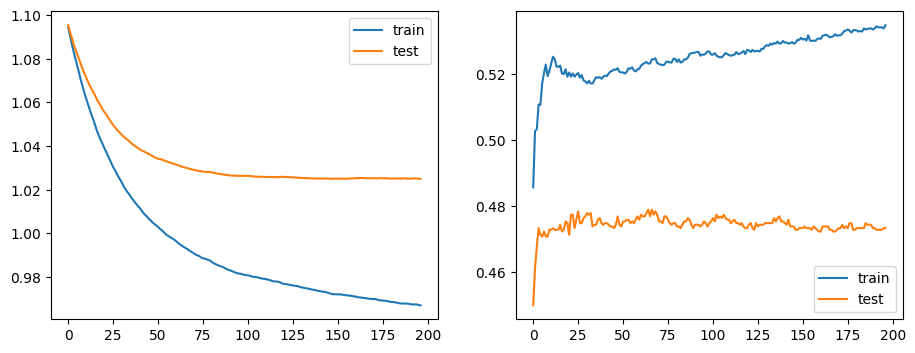

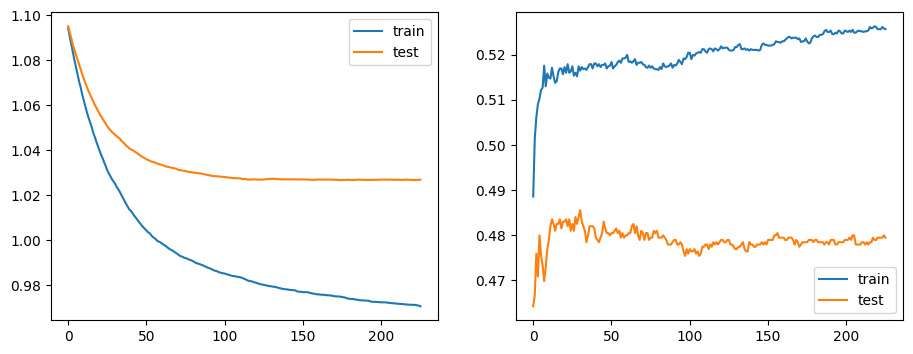

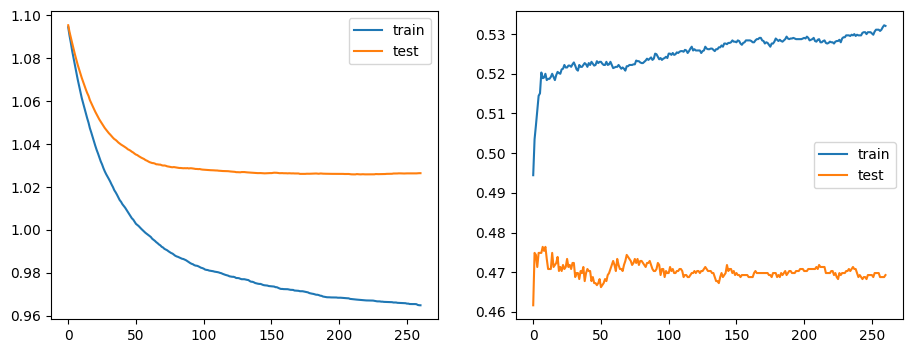

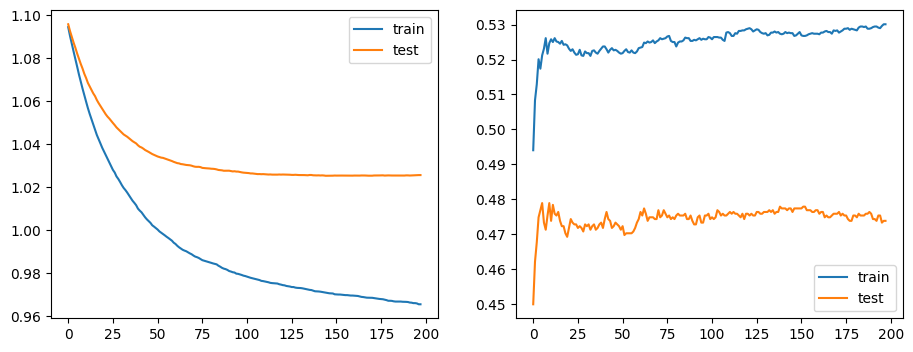

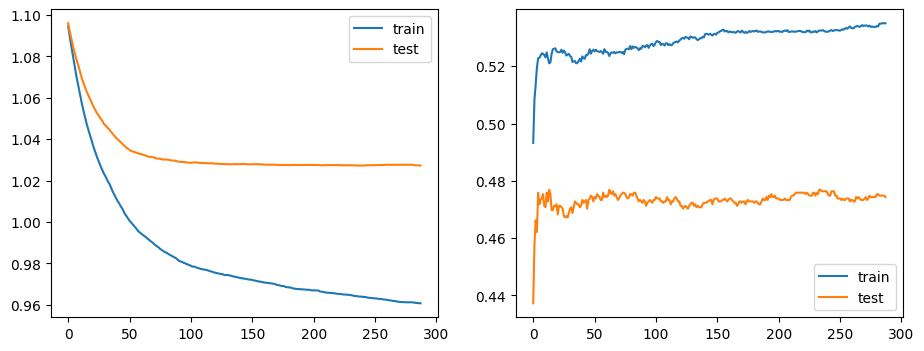

In [186]:
# Plot log loss and accuracy for training and validation sets
# results = model.evals_result_
for result in results:
    fig, ax = plt.subplots(1,2, figsize=(11,4))
    ax[0].plot(result['validation_0']['mlogloss'], label='train')
    ax[0].plot(result['validation_1']['mlogloss'], label='test')
    ax[1].plot((np.ones_like(result['validation_0']['merror'])-result['validation_0']['merror']), label='train')
    ax[1].plot((np.ones_like(result['validation_0']['merror'])-result['validation_1']['merror']), label='test')
    ax[0].legend()
    ax[1].legend()
plt.show()

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.81 0.   0.19]
 [0.71 0.01 0.28]
 [0.58 0.   0.42]]


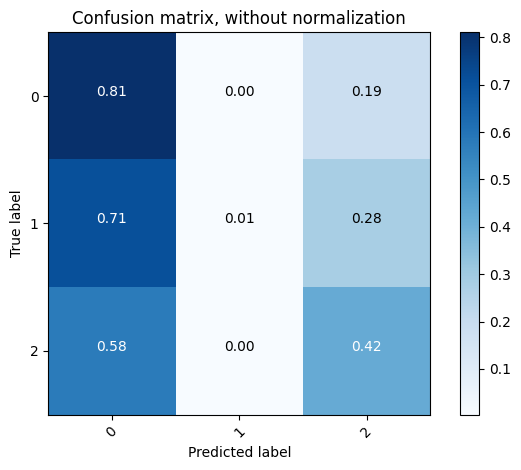

In [169]:
cnf_matrix = confusion_matrix(y_test, ypred, labels=labels)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels,
                      title='Confusion matrix, without normalization', normalize=True)
plt.show()

### CATBoost

In [ ]:
# Best for CatboostClassifier

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to be optimized
    param = {
        "objective": "MultiClass",  # Objective function for multi-class classification
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 0.8, log=True),  # Subsample ratio of columns for each level
        "depth": trial.suggest_int("depth", 3, 7),  # Depth of the tree
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),  # Boosting type
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),  # Bootstrap type
        "iterations": trial.suggest_int("iterations", 50, 10000),  # Number of boosting iterations
        "min_child_samples": trial.suggest_int("min_child", 5, 10),  # Minimum number of samples in a leaf
        "eval_metric": "MultiClass",  # Evaluation metric for multi-class classification
    }

    # Add specific hyperparameters based on the bootstrap type
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)  # Bagging temperature for Bayesian bootstrap
    else:
        param["subsample"] = trial.suggest_float("subsample", 0.1, 0.5, log=True)  # Subsample ratio for Bernoulli or MVS bootstrap

    # Initialize the CatBoost classifier with the specified hyperparameters
    gbm = CatBoostClassifier(**param)
    pruning_callback = CatBoostPruningCallback(trial, "MultiClass")  # Pruning callback for early stopping

    mean_accuracy = 0  # Initialize mean accuracy
    cv = StratifiedKFold(n_splits=5, shuffle=False)  # Stratified k-fold cross-validation
    for i, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        # Split the data into training and validation sets based on the current fold
        x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        train_y, val_y = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Train the model on the training set and validate on the validation set
        gbm.fit(
            x_train,
            train_y,
            eval_set=[(X_valid, y_valid)],  # Evaluate on the validation set
            verbose=0,  # No verbose output
            early_stopping_rounds=50,  # Stop early if no improvement after 50 rounds
            callbacks=[pruning_callback],  # Include pruning callback
        )
        
        # Manually check for pruning
        pruning_callback.check_pruned()

        # Make predictions on the validation set
        y_pred = gbm.predict(x_val)
        
        # Calculate and accumulate the accuracy score
        mean_accuracy += accuracy_score(val_y, y_pred)

    return mean_accuracy / 5  # Return average accuracy over all folds

# Create an Optuna study with a pruner for early stopping and direction to maximize accuracy
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
)
# Optimize the study with 1000 trials and a timeout of 6000 seconds
study.optimize(objective, n_trials=1000, timeout=6000)

# Print the number of finished trials
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

# Print the value (accuracy) and parameters of the best trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [21]:
# Best hyperparameter configurations from different trials
c2={'colsample_bylevel': 0.5037201276210013, 'learning_rate':0.015, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'iterations': 258, 'min_child_samples': 7, 'subsample': 0.30632248177068655}
c3={'colsample_bylevel': 0.6124322643181608, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'iterations': 6081, 'min_child_samples': 8, 'bagging_temperature': 5.223879454435309}
c4={'colsample_bylevel': 0.444042843754358, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'iterations': 7206, 'min_child_samples': 7, 'subsample': 0.3004317071745665}

In [170]:
# Initialize stratified k-fold cross-validation with 5 splits
cv = StratifiedKFold(n_splits=5, shuffle=False)
mean = 0
results = []
for i, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        train_y, val_y = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = CatBoostClassifier(**c2, custom_metric=['Accuracy', 'MultiClass'], use_best_model=True)
        model.fit(x_train, train_y,eval_set=[(x_train,train_y), (X_valid, y_valid)], early_stopping_rounds = 10, verbose=0)
        results.append(model.evals_result_)
        y_pred = model.predict(x_val)
        mean += accuracy_score(val_y, y_pred)
print(mean/5)
ypred = model.predict(X_test)
accuracy_score(ypred, y_test)

0.49574207861882574


0.4863876472978464

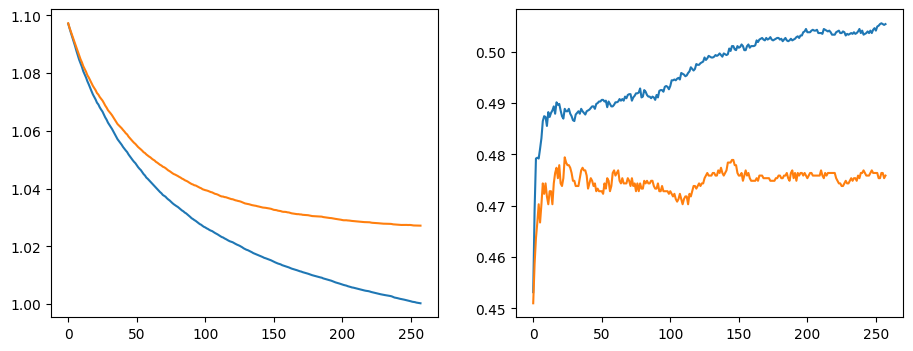

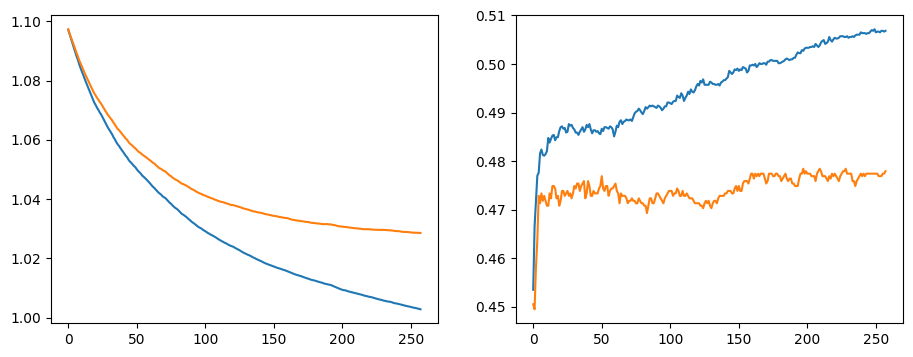

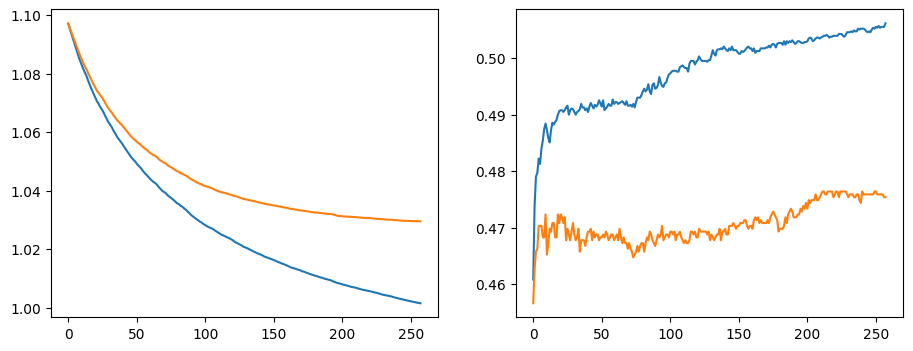

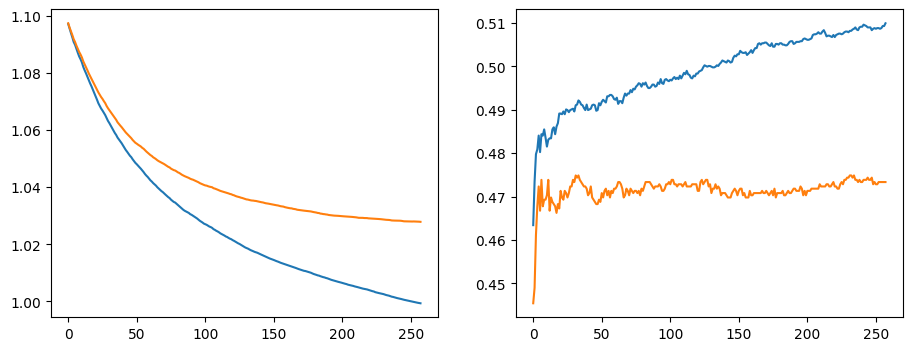

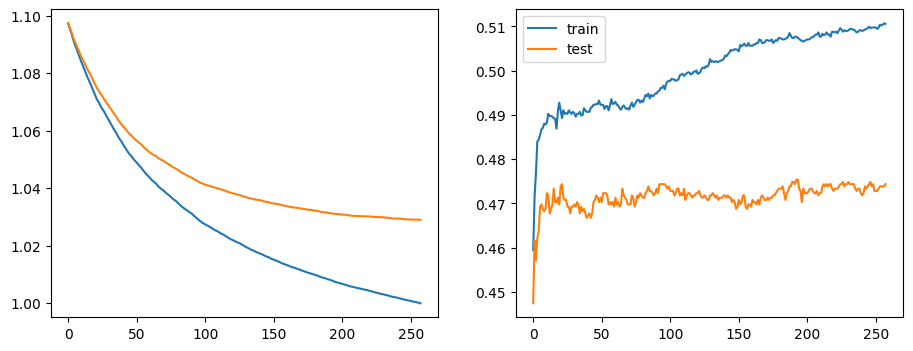

In [171]:
# Plot log loss and accuracy for training and validation sets
# results = model.evals_result_
for result in results:
    fig, ax = plt.subplots(1,2, figsize=(11,4))
    ax[0].plot(result['validation_0']['MultiClass'], label='train')
    ax[0].plot(result['validation_1']['MultiClass'], label='test')
    ax[1].plot(result['validation_0']['Accuracy'], label='train')
    ax[1].plot(result['validation_1']['Accuracy'], label='test')
plt.legend()
plt.show()

Normalized confusion matrix
[[0.87 0.   0.13]
 [0.78 0.   0.22]
 [0.65 0.   0.35]]


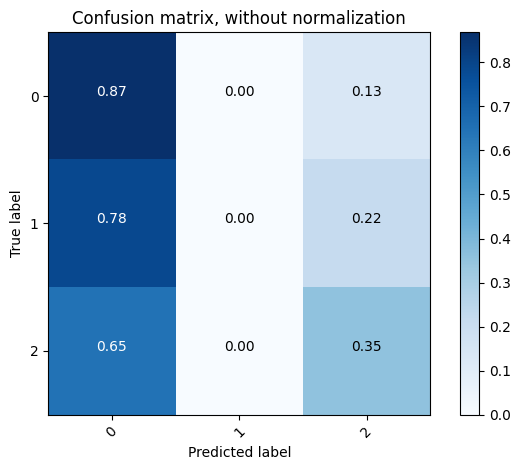

In [172]:
cnf_matrix = confusion_matrix(y_test, ypred, labels=labels)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels,
                      title='Confusion matrix, without normalization', normalize=True)
plt.show()

# Multi Layer Perceptron

In [22]:
# Convert the labels to a categorical format suitable for neural networks
y_train_nn = keras.utils.to_categorical(y_train)
y_val_nn = keras.utils.to_categorical(y_valid)

In [23]:
# Import the necessary modules from Keras
from tensorflow import keras

# Define the architecture of the Multi-Layer Perceptron (MLP) using the Sequential API
mlp = keras.Sequential(
    [
        # Input layer with 9 units and sigmoid activation function
        # The input_shape is set to the number of features in the training data
        keras.layers.Dense(units=9, activation="sigmoid", input_shape=(X_train.shape[-1],)),
        
        # Dropout layer with 70% dropout rate to prevent overfitting
        keras.layers.Dropout(0.7),
        
        # Hidden layer with 200 units and ReLU activation function
        keras.layers.Dense(units=200, activation="relu"),
        
        # Hidden layer with 200 units and ReLU activation function
        keras.layers.Dense(units=200, activation="relu"),
        
        # Dropout layer with 20% dropout rate to prevent overfitting
        keras.layers.Dropout(0.2),
        
        # Hidden layer with 200 units and ReLU activation function
        keras.layers.Dense(units=200, activation="relu"),
        
        # Hidden layer with 200 units and ReLU activation function
        keras.layers.Dense(units=200, activation="relu"),
        
        # Dropout layer with 10% dropout rate to prevent overfitting
        keras.layers.Dropout(0.1),
        
        # Output layer with 3 units (number of classes) and softmax activation function for multi-class classification
        keras.layers.Dense(units=3, activation="softmax"),
    ]
)

# Save the initial weights of the model
initial_weights = mlp.get_weights()

In [24]:
# Set the learning rate for the optimizer
learning_rate = 0.001

# Compile the MLP model with the Adam optimizer, categorical cross-entropy loss, and accuracy metric
mlp.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")]
)

# Define early stopping callback to stop training when the validation loss doesn't improve for 10 epochs
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,     # Number of epochs to wait before stopping if no improvement
    restore_best_weights=True,  # Restore the weights of the best epoch
)

# Reset the model weights to the initial weights
mlp.set_weights(initial_weights)

# Train the MLP model on the training data with validation data
history = mlp.fit(
    X_train, y_train_nn,
    epochs=100,  # Maximum number of epochs to train
    batch_size=256,  # Number of samples per gradient update
    validation_data=(X_valid, y_val_nn),  # Data for validation
    verbose=0,  # Suppress detailed output
    callbacks=[early_stopping]  # Use early stopping callback
)

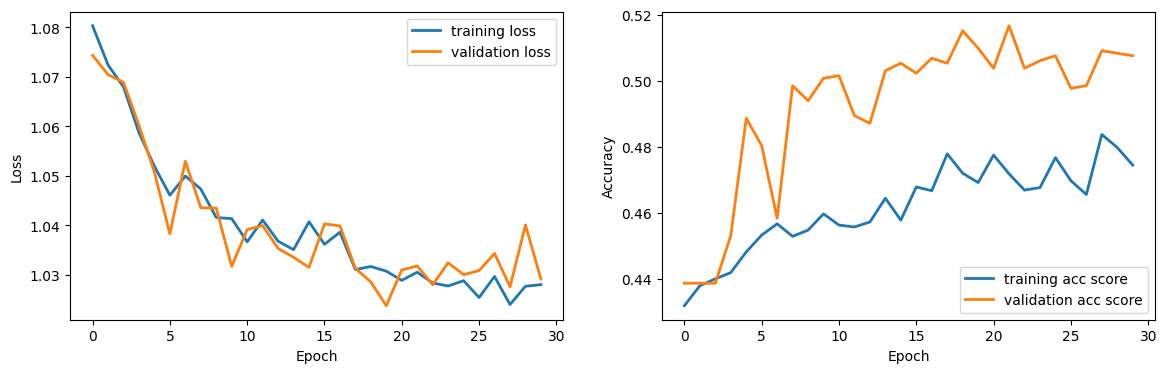

In [260]:
# Plot the training and validation loss and accuracy scores
logs = pd.DataFrame(history.history)
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[:, "loss"], lw=2, label='training loss')
plt.plot(logs.loc[:, "val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[:, "accuracy"], lw=2, label='training acc score')
plt.plot(logs.loc[:, "val_accuracy"], lw=2, label='validation acc score')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.show()

## Ensemble the Models

The idea is to ensemble the models already build to get a better prediction.

In [25]:
from sklearn.svm import SVC
# Define the base models for the ensemble
cat1 = CatBoostClassifier(**c2, custom_metric=['MultiClass', 'Accuracy'], use_best_model=True)
cat2 = CatBoostClassifier(**c3, custom_metric=['MultiClass', 'Accuracy'], use_best_model=True)
cat3 = CatBoostClassifier(**c4, custom_metric=['MultiClass', 'Accuracy'], use_best_model=True)

xgb2 = XGBClassifier(**b2, num_classes=3, eval_metric=['merror', 'mlogloss'])
xgb3 = XGBClassifier(**b3, num_classes=3, eval_metric=['merror', 'mlogloss'])
xgb4 = XGBClassifier(**b4, num_classes=3, eval_metric=['merror', 'mlogloss'])

svm = SVC(kernel="rbf", decision_function_shape="ovr", C=15.124603132444244, gamma=8.173535719687206e-05, probability=True)
pipe_svm = Pipeline(steps=[('scale', StandardScaler()), ('cut', PCA(154)), ('classify', svm)])
knn = KNeighborsClassifier(n_neighbors=175, n_jobs=-1)

In [26]:
# Generate out-of-fold predictions

# List of models to be used for stacking
models = [cat1, cat2, cat3, xgb2, xgb3, xgb4, pipe_svm, mlp, knn]

# Initialize stratified k-fold cross-validation with 5 splits
cv = StratifiedKFold(n_splits=5, shuffle=False)

# Number of classes in the target variable
num_classes = 3

# Initialize an array to store out-of-fold predictions for stacking
X_stack = np.zeros((X_train.shape[0], num_classes * len(models)))

# Iterate through each fold in the cross-validation split
for i, (train_idx, oof_idx) in enumerate(cv.split(X_train, y_train)):
    # Iterate through each model in the list
    for k, model in enumerate(models):
        # Split the data into training and out-of-fold (oof) sets based on the current fold
        x_train, x_oof = X_train.iloc[train_idx], X_train.iloc[oof_idx]
        train_y, oof_y = y_train.iloc[train_idx], y_train.iloc[oof_idx]

        # Check the model type and fit the model accordingly
        if model.__class__.__name__ == 'CatBoostClassifier':
            # Fit CatBoostClassifier with early stopping
            model.fit(x_train, train_y, eval_set=[(X_valid, y_valid)], early_stopping_rounds=10, verbose=0)
            # Get the predicted probabilities for the out-of-fold set
            pred_oof = model.predict_proba(x_oof)
        
        elif model.__class__.__name__ == 'XGBClassifier':
            # Fit XGBClassifier with early stopping
            model.fit(x_train, train_y, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=0)
            # Get the predicted probabilities for the out-of-fold set
            pred_oof = model.predict_proba(x_oof)
        
        elif model.__class__.__name__ == 'Sequential':
            # Reset the model weights to the initial weights
            model.set_weights(initial_weights)
            # Convert the training labels to categorical format
            y_train_nn = keras.utils.to_categorical(train_y)
            # Fit the neural network model
            model.fit(x_train, y_train_nn, epochs=100, batch_size=256, validation_data=(X_valid, y_val_nn), verbose=0, callbacks=[early_stopping])
            # Get the predicted probabilities for the out-of-fold set
            pred_oof = model.predict(x_oof)
        
        else:
            # Fit other models (e.g., SVM, KNN) without early stopping
            model.fit(x_train, train_y)
            # Get the predicted probabilities for the out-of-fold set
            pred_oof = model.predict_proba(x_oof)
        
        # Store the predicted probabilities in the stacking array
        X_stack[oof_idx, num_classes * k:num_classes * (k + 1)] = pred_oof

47/47 [==============================] - 0s 1ms/step


In [27]:
S_train, S_test, ys_train, ys_test = train_test_split(X_stack, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [28]:
from sklearn.calibration import LinearSVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

# Initialize the stacking model using Logistic Regression with cross-validation
stacker = LogisticRegressionCV()

# Fit the stacking model on the out-of-fold predictions (X_stack) and the true labels (y_train)
stacker.fit(X_stack, y_train)

In [30]:
# Define a function to fit a model and predict on new data
def fit_predict(model, X_train, y_train, X_predict, X_valid, y_valid, num_classes, probabilities=True, **fit_params):
    # Initialize the prediction array based on whether probabilities are needed
    if probabilities:
        pred = np.zeros((X_predict.shape[0], num_classes))  # Initialize prediction array for probabilities
    else:
        pred = np.zeros((X_predict.shape[0], ))  # Initialize prediction array for class labels

    # Check the model type and fit the model accordingly
    if model.__class__.__name__ == 'CatBoostClassifier':
        # Fit CatBoostClassifier with early stopping
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=10, verbose=0)
        # Predict probabilities or class labels based on the 'probabilities' parameter
        pred_oof = model.predict_proba(X_predict) if probabilities else model.predict(X_predict)
    
    elif model.__class__.__name__ == 'XGBClassifier':
        # Fit XGBClassifier with early stopping
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=0)
        # Predict probabilities or class labels based on the 'probabilities' parameter
        pred_oof = model.predict_proba(X_predict) if probabilities else model.predict(X_predict)
    
    elif model.__class__.__name__ == 'Sequential':
        # Reset the model weights to the initial weights
        model.set_weights(initial_weights)
        # Convert the training and validation labels to categorical format
        y_train_nn = keras.utils.to_categorical(y_train)
        y_val_nn = keras.utils.to_categorical(y_valid)
        # Fit the neural network model
        model.fit(X_train, y_train_nn, epochs=100, batch_size=256, validation_data=(X_valid, y_val_nn), verbose=0, callbacks=[early_stopping])
        # Predict probabilities or class labels based on the 'probabilities' parameter
        pred_oof = model.predict(X_predict) if probabilities else np.argmax(model.predict(X_predict), axis=1)
    
    else:
        # Fit other models (e.g., SVM, KNN) without early stopping
        model.fit(X_train, y_train)
        # Predict probabilities or class labels based on the 'probabilities' parameter
        pred_oof = model.predict_proba(X_predict) if probabilities else model.predict(X_predict)
    
    # Set the predictions to the prediction array
    pred = pred_oof
    return pred

In [287]:
# Cross validation of stacked ensemble
cv = StratifiedKFold(n_splits=7, shuffle=False)

mean = 0
results_stack = []
predictions = np.zeros((X_test.shape[0], num_classes*len(models)))
for i, (train_idx, val_idx) in enumerate(cv.split(X_test, y_test)):
    x_train, x_val = X_test.iloc[train_idx], X_test.iloc[val_idx]
    train_y, val_y = y_test.iloc[train_idx], y_test.iloc[val_idx]
    for k, model in enumerate(models):
        pred_oof = fit_predict(model, x_train, train_y, x_val, X_valid, y_valid, 3)
        predictions[val_idx, num_classes*k:num_classes*(k+1)] = pred_oof
    stack_pred = stacker.predict(predictions[val_idx,:])
    results_stack.append(accuracy_score(val_y, stack_pred))

8/8 [==============================] - 0s 2ms/step


In [268]:
# Cross validation of individual models
cv = StratifiedKFold(n_splits=7, shuffle=False)

results = []
for model in models:
    model_performance = []
    for i, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        train_y, val_y = y_train.iloc[train_idx], y_train.iloc[val_idx]
        pred = fit_predict(model, x_train, train_y, x_val, X_valid, y_valid, num_classes, probabilities=False)
        model_performance.append(accuracy_score(val_y, pred))
    results.append(model_performance)

24/24 [==============================] - 0s 2ms/step


In [280]:
performance_df = pd.DataFrame(np.array(results).T)
performance_df['stack'] = results_stack
performance_df

0         1         2         3         4         5         6  \
0  0.519841  0.509259  0.525132  0.511905  0.513228  0.518519  0.513228   
1  0.511905  0.509259  0.506614  0.498677  0.501323  0.507937  0.498677   
2  0.502646  0.494709  0.502646  0.497354  0.498677  0.493386  0.492063   
3  0.486093  0.487417  0.478146  0.500662  0.503311  0.480795  0.496689   
4  0.495364  0.486093  0.494040  0.487417  0.486093  0.484768  0.495364   
5  0.500662  0.508609  0.499338  0.501987  0.501987  0.515232  0.503311   
6  0.494040  0.500662  0.498013  0.484768  0.484768  0.488742  0.499338   

          7         8     stack  
0  0.515873  0.506614  0.468354  
1  0.507937  0.501323  0.533898  
2  0.493386  0.488095  0.525424  
3  0.478146  0.479470  0.508475  
4  0.484768  0.484768  0.525424  
5  0.491391  0.503311  0.529661  
6  0.486093  0.499338  0.491525

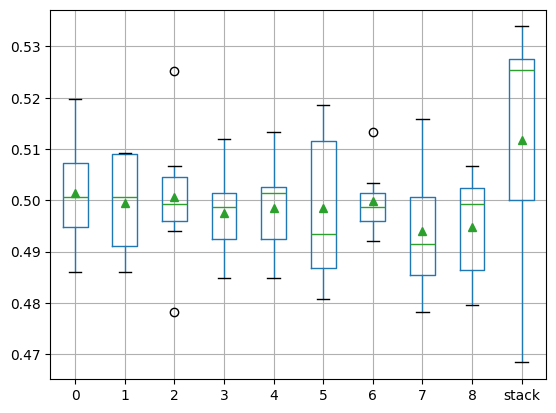

In [289]:
# Boxplot of base models vs stacked ensemble performance
performance_df.boxplot(showmeans=True)
plt.show()

In [292]:
performance_df.mean()

0        0.501507
1        0.499430
2        0.500561
3        0.497539
4        0.498484
5        0.498483
6        0.499810
7        0.493942
8        0.494703
stack    0.511823
dtype: float64

## Final Prediction & Submission

In [31]:
# Load test team statistics
test_home_team_statistics_df = pd.read_csv(
    'test_home_team_statistics_df.csv', index_col=0)
test_away_team_statistics_df = pd.read_csv(
    'test_away_team_statistics_df.csv', index_col=0)

test_home = test_home_team_statistics_df.iloc[:, :]
test_away = test_away_team_statistics_df.iloc[:, :]

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

test_data = pd.concat([test_home, test_away], join='inner', axis=1)

test_data = test_data.replace({np.inf: np.nan, -np.inf: np.nan})
index = test_data.index

In [32]:
# Impute missing values in the test data using the KNNImputer
from sklearn.impute import KNNImputer

neighbor_imputer = KNNImputer(n_neighbors=200)
test_data = neighbor_imputer.fit_transform(test_data)

In [33]:
test_data = pd.DataFrame(test_data, columns=neighbor_imputer.get_feature_names_out())

In [132]:
test_data.head()

HOME_TEAM_SHOTS_TOTAL_season_sum  HOME_TEAM_SHOTS_OFF_TARGET_season_sum  \
0                               3.0                                    5.0   
1                               3.0                                    4.0   
2                               7.0                                    8.0   
3                               5.0                                    5.0   
4                               5.0                                    6.0   

   HOME_TEAM_SHOTS_ON_TARGET_season_sum  HOME_TEAM_SAVES_season_sum  \
0                                   1.0                        10.0   
1                                   2.0                         2.0   
2                                   8.0                         0.0   
3                                   9.0                         3.0   
4                                   3.0                         2.0   

   HOME_TEAM_CORNERS_season_sum  HOME_TEAM_FOULS_season_sum  \
0                           6.0                         7.0   
1                           4.0                        10.0   
2                          10.0                         4.0   
3                           5.0                         8.0   
4                           2.0                         9.0   

   HOME_TEAM_YELLOWCARDS_season_sum  HOME_TEAM_REDCARDS_season_sum  \
0                               6.0                            3.0   
1                               7.0                           10.0   
2                               2.0                            2.0   
3                               6.0                            8.0   
4                              10.0                           10.0   

   HOME_TEAM_OFFSIDES_season_sum  HOME_TEAM_ATTACKS_season_sum  ...  \
0                            2.0                           7.0  ...   
1                            3.0                           2.0  ...   
2                            0.0                           6.0  ...   
3                            6.0                           2.0  ...   
4                            5.0                           8.0  ...   

   AWAY_TEAM_BALL_POSSESSION_5_last_match_std  \
0                                         5.0   
1                                         0.0   
2                                         8.0   
3                                         5.0   
4                                         8.0   

   AWAY_TEAM_FOULS_5_last_match_std  AWAY_TEAM_YELLOWCARDS_5_last_match_std  \
0                               2.0                                     6.0   
1                              10.0                                     0.0   
2                               4.0                                    10.0   
3                               5.0                                     1.0   
4                               4.0                                     3.0   

   AWAY_TEAM_REDCARDS_5_last_match_std  AWAY_TEAM_OFFSIDES_5_last_match_std  \
0                                  0.0                                  1.0   
1                                  0.0                                  3.0   
2                                  0.0                                  0.0   
3                                  5.0                                  4.0   
4                                  0.0                                  6.0   

   AWAY_TEAM_ATTACKS_5_last_match_std  AWAY_TEAM_PENALTIES_5_last_match_std  \
0                                 4.0                                   0.0   
1                                 6.0                                   8.0   
2                                 2.0                                   0.0   
3                                 5.0                                  10.0   
4                                 5.0                                   0.0   

   AWAY_TEAM_SUBSTITUTIONS_5_last_match_std  \
0                                       8.0   
1                                       5.0   
2                  

In [133]:
# Prediction of stacked ensemble data
predictions = np.zeros((test_data.shape[0], num_classes*len(models)))
for k, model in enumerate(models):
    pred_oof = fit_predict(model, X_train, y_train, test_data, X_valid, y_valid, 3)
    predictions[:, num_classes*k:num_classes*(k+1)] = pred_oof
stack_pred = stacker.predict(predictions[:,:])

793/793 [==============================] - 1s 1ms/step


In [42]:
# Convert the predicted class labels to one-hot encoded format for submission
predictions = np.zeros((stacked.shape[0], 3))
predictions[np.arange(stacked.shape[0]), stacked] = 1
predictions = pd.DataFrame(predictions).astype("int")
predictions.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']
predictions.index = index
submission = predictions.reset_index()
submission.to_csv('submission_TBF_v1.csv', index=False)

# End :)